***Note to self, also look into separating data by other 'flags', like schools that offer certain degrees
    Tuition fees (in and out of state) is a good looking variable
    Cost of attendance: family income, academic ability, financial aid (Pell grant recipients is a good way to measure school’s aid to low income students)
Value of returns: graduation rates, earnings, employment, loan payments

CIP variables are filled out, but just 1 or 0 if they offer the degree
INEXPFTE is instructional expediture per student
PFTFAC percentage of faculty that is full time
IND_INC_AVG and DEP_INC_AVG is average family income for independent and dependent students
ADM_RATE, only 2800 data points though
SAT and ACT stuff only 1300 points
UGDS number of degree seeking undergrads- lots of points
RET_FT4 retention rate for 1st year at 4yr schools
mn_earn_wne_p8 Mean earnings of students working and not enrolled 8 years after entry

In [1]:
####Combine data files and select columns to be used in Lasso Model
import pandas as pd
import seaborn as sns

%matplotlib inline

# First values are the independent variables, last value is the dependent
# Trying to see if instructional expediture per student (INEXPFTE), percentage of faculty that is full time (PFTFAC),
# and number of degree seeking undergrads (UGDS) can predict future earnings (mn_earn_wne_p9- mean earning of students 
# working and not enrolled 9 years after entry)


FILE_PATHS = ['./datasets/merged_2013_PP.csv']

combined_df = []

for path in FILE_PATHS:
    df = pd.read_csv(path, low_memory=False, encoding='latin-1')
    combined_df.append(df)

combined_df = pd.concat(combined_df)

In [2]:
combined_df.head()

UNITID    OPEID  opeid6                               INSTNM        CITY  \
0  100654   100200    1002             Alabama A & M University      Normal   
1  100663   105200    1052  University of Alabama at Birmingham  Birmingham   
2  100690  2503400   25034                   Amridge University  Montgomery   
3  100706   105500    1055  University of Alabama in Huntsville  Huntsville   
4  100724   100500    1005             Alabama State University  Montgomery   

  STABBR         ZIP                                       AccredAgency  \
0     AL       35762  Southern Association of Colleges and Schools C...   
1     AL  35294-0110  Southern Association of Colleges and Schools C...   
2     AL  36117-3553  Southern Association of Colleges and Schools C...   
3     AL       35899  Southern Association of Colleges and Schools C...   
4     AL  36104-0271  Southern Association of Colleges and Schools C...   

                          INSTURL  \
0                   www.aamu.edu/   
1                     www.uab.edu   
2       www.amridgeuniversity.edu   
3                     www.uah.edu   
4  www.alasu.edu/email/index.aspx   

                                              NPCURL         ...          \
0     galileo.aamu.edu/netpricecalculator/npcalc.htm         ...           
1    www.collegeportraits.org/AL/UAB/estimator/agree         ...           
2  tcc.noellevitz.com/(S(miwoihs5stz5cpyifh4nczu0...         ...           
3                                    finaid.uah.edu/         ...           
4  www.alasu.edu/cost-aid/forms/calculator/index....         ...           

   PELL_RPY_3YR_RT_SUPP  NOPELL_RPY_3YR_RT_SUPP  FEMALE_RPY_3YR_RT_SUPP  \
0           0.443586698             0.452513966             0.484818805   
1           0.732297853             0.795454545             0.760521886   
2           0.600877193                   0.775             0.610465116   
3           0.738341969             0.851405622             0.768378651   
4           0.320016821             0.380829016             0.364423718   

   MALE_RPY_3YR_RT_SUPP  FIRSTGEN_RPY_3YR_RT_SUPP  \
0                 0.406               0.423580786   
1           0.755344418               0.751552795   
2           0.686567164               0.632653061   
3            0.79844098               0.778156997   
4           0.286530612               0.315737052   

   NOTFIRSTGEN_RPY_3YR_RT_SUPP  C150_L4_POOLED_SUPP  C150_4_POOLED_SUPP  \
0                   0.44245283                  NaN         0.308718313   
1                  0.765074771                  NaN         0.508549808   
2                         0.65                  NaN   PrivacySuppressed   
3                  0.791666667                  NaN         0.478211346   
4                  0.334633385                  NaN         0.257481955   

   C200_L4_POOLED_SUPP  C200_4_POOLED_SUPP  
0                  NaN         0.351685564  
1                  NaN         0.473092383  
2                  NaN   PrivacySuppressed  
3                  NaN         0.494129398  
4                  NaN         0.293651627  

[5 rows x 1729 columns]

In [3]:
df = combined_df

### Only looking at bachelors degree schools
df = df.loc[df['PREDDEG'] == 3]

COLUMNS = ['GRAD_DEBT_MDN', 'INEXPFTE', 'PFTFAC', 'UGDS', 'ADM_RATE', 'ACTCMMID', 'AVGFACSAL', 'UGDS_ASIAN',
           'WDRAW_DEBT_N', 'CDR3', 'NOTFIRSTGEN_DEBT_N', 'TUITFTE', 'UGDS_NRA', 'UGDS_NHPI', 'UGDS_HISP', 'UGDS_2MOR',
          'UGDS_BLACK', 'UGDS_WHITE']

df = df[COLUMNS].dropna(subset = COLUMNS)
df = df.astype(str)
for column in COLUMNS:
    df = df[df[column] != 'PrivacySuppressed']
df = df.astype(float)
print(len(df.index))



1262


In [5]:
from sklearn.grid_search import GridSearchCV
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
import numpy as np

### Preprocess data columns to have zero mean and unit variance (will help Lasso work better)

X = df[df.columns[1:]].values

y = df[df.columns[0]].values

X_scaled = preprocessing.scale(X)
X_scaled 

array([[ -3.35285072e-01,   7.30519568e-01,  -2.06010478e-01, ...,
         -1.17668233e+00,   4.60378230e+00,  -2.80378302e+00],
       [  8.63005359e-01,   8.38610288e-01,   7.89626586e-01, ...,
          2.95694245e-01,   7.41688157e-01,  -1.27673544e-01],
       [ -1.02608512e-01,  -2.64347418e-01,  -7.27357155e-04, ...,
         -4.87575849e-01,   2.63820494e-02,   3.52882204e-01],
       ..., 
       [  9.87025776e-01,   1.22514270e+00,  -1.03369470e-02, ...,
          7.45111512e-01,   7.37217494e-01,  -2.61291484e-01],
       [ -6.84975941e-01,   7.16683956e-01,   1.24949420e+00, ...,
         -1.53723022e-01,  -4.54773074e-01,   7.69676408e-01],
       [ -1.27191350e-01,   5.91298721e-01,   3.75578609e-01, ...,
          4.88301645e-01,  -2.08886600e-01,  -2.03103578e-02]])

In [6]:
X = X_scaled    
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

parameters = {'alpha':[.001, .01, 0.1, 1, 10, 50, 100, 1000]}
model = linear_model.Lasso() 
clf = GridSearchCV(model, parameters, cv=8, n_jobs=6)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
mse = mean_squared_error(predictions, y_test)
print("Mean squared error: {}".format(mse))

Mean squared error: 9978175.86027447


In [7]:
clf.best_estimator_

Lasso(alpha=50, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [13]:
lasso = linear_model.Lasso(alpha=50)
lasso.fit(X_train, y_train)
print("Lasso coefficients: {}".format(lasso.coef_))

Lasso coefficients: [ -793.04199561  -223.9624714   -344.65149212   567.80648938  -489.06342344
  -172.05333613  -318.56135194     0.             6.89600847   291.91262501
  1914.49884207  -126.37501893   -97.16885616  -623.68135683  -313.15189053
  1514.9582631      0.        ]


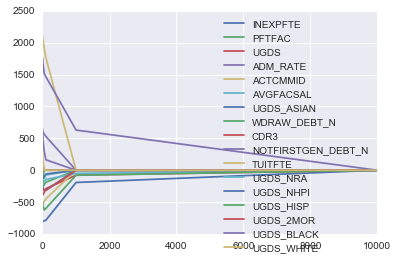

In [14]:
%matplotlib inline
lasso_alphas = [.001, .01, 0.1, 1, 10, 50, 100, 1000, 10000]

lasso_coeff = {}
for alpha in lasso_alphas:
    lasso = linear_model.Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)
    lasso_coeff[alpha] = lasso.coef_
lpd = pd.DataFrame.from_dict(lasso_coeff, orient='index', )
lpd.columns = df.columns[1:]
lpd=lpd.sort_index()
lpd.plot()

In [15]:
from sklearn.metrics import r2_score
r2_score(y_test, predictions) 

0.41043788654952496

In [11]:
#PCIP14 is % of degrees granted in engineering
#PCIP52 is % business